# first import libraries



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
import cv2
import os
import glob as gb
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam


<ipython-input-2-9d507c61f351>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')



# check the Train folder

In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/drive/MyDrive/datasets

brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/drive/MyDrive/datasets/brain-tumor-mri-dataset.zip -d /content/drive/MyDrive/datasets/


Archive:  /content/drive/MyDrive/datasets/brain-tumor-mri-dataset.zip
replace /content/drive/MyDrive/datasets/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
trainpath = '/content/drive/MyDrive/datasets/'
for folder in  os.listdir(trainpath + 'Training') :
    files = gb.glob(pathname= str( trainpath +'Training//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 1321 in folder glioma
For training data , found 1339 in folder meningioma
For training data , found 1595 in folder notumor
For training data , found 1457 in folder pituitary


# check the test folder

In [5]:
testpath  = '/content/drive/MyDrive/datasets/'
for folder in  os.listdir(testpath + 'Testing') :
    files = gb.glob(pathname= str( testpath +'Testing//' + folder + '/*.jpg'))
    print(f'For testing data , found {len(files)} in folder {folder}')

For testing data , found 300 in folder glioma
For testing data , found 306 in folder meningioma
For testing data , found 405 in folder notumor
For testing data , found 300 in folder pituitary


In [6]:
code = {'glioma' : 0 , 'meningioma' : 1, 'notumor' : 2 , 'pituitary' : 3  }
#create a dictionary with their names & index , also create a function to get the index back
def convert_code (k):
    for x , y in code.items():
        if y == k :
            return x

In [8]:
X_train = [] #Training Dataset
y_train = [] #Training Labels
for folder in  os.listdir(trainpath +'Training') :
    files = gb.glob(pathname= str( trainpath +'Training//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        X_train.append(list(image))
        y_train.append(code[folder])

In [9]:
print(f'we have {len(X_train)} items in X_train')

we have 5712 items in X_train


 we have have a look to random pictures in X_train , and to adjust their title using the y valu

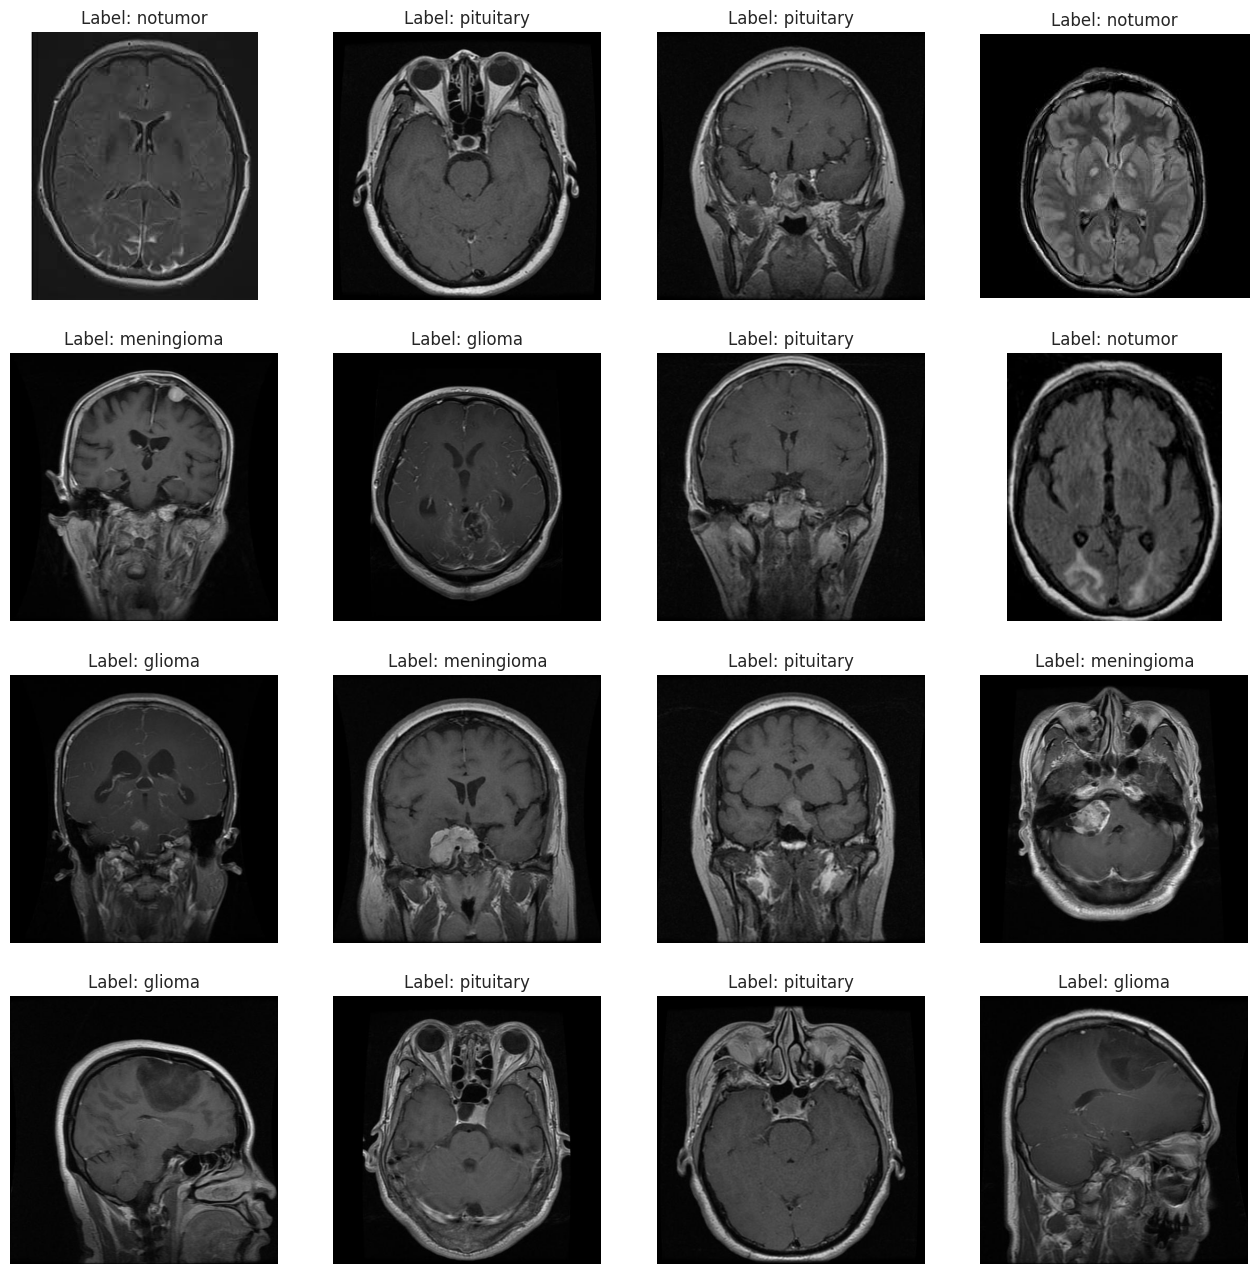

In [10]:
plt.figure(figsize=(16,16))
for ax , i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,ax+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title('Label: '+convert_code(y_train[i]))

In [11]:
X_test = [] # testing Dataset
y_test = [] # testing Labels
for folder in  os.listdir(trainpath +'Testing') :
    files = gb.glob(pathname= str( trainpath +'Testing//' + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        X_train.append(list(image))
        y_train.append(code[folder])

we have have a look to random pictures in x_test , and to adjust their title using the y valu

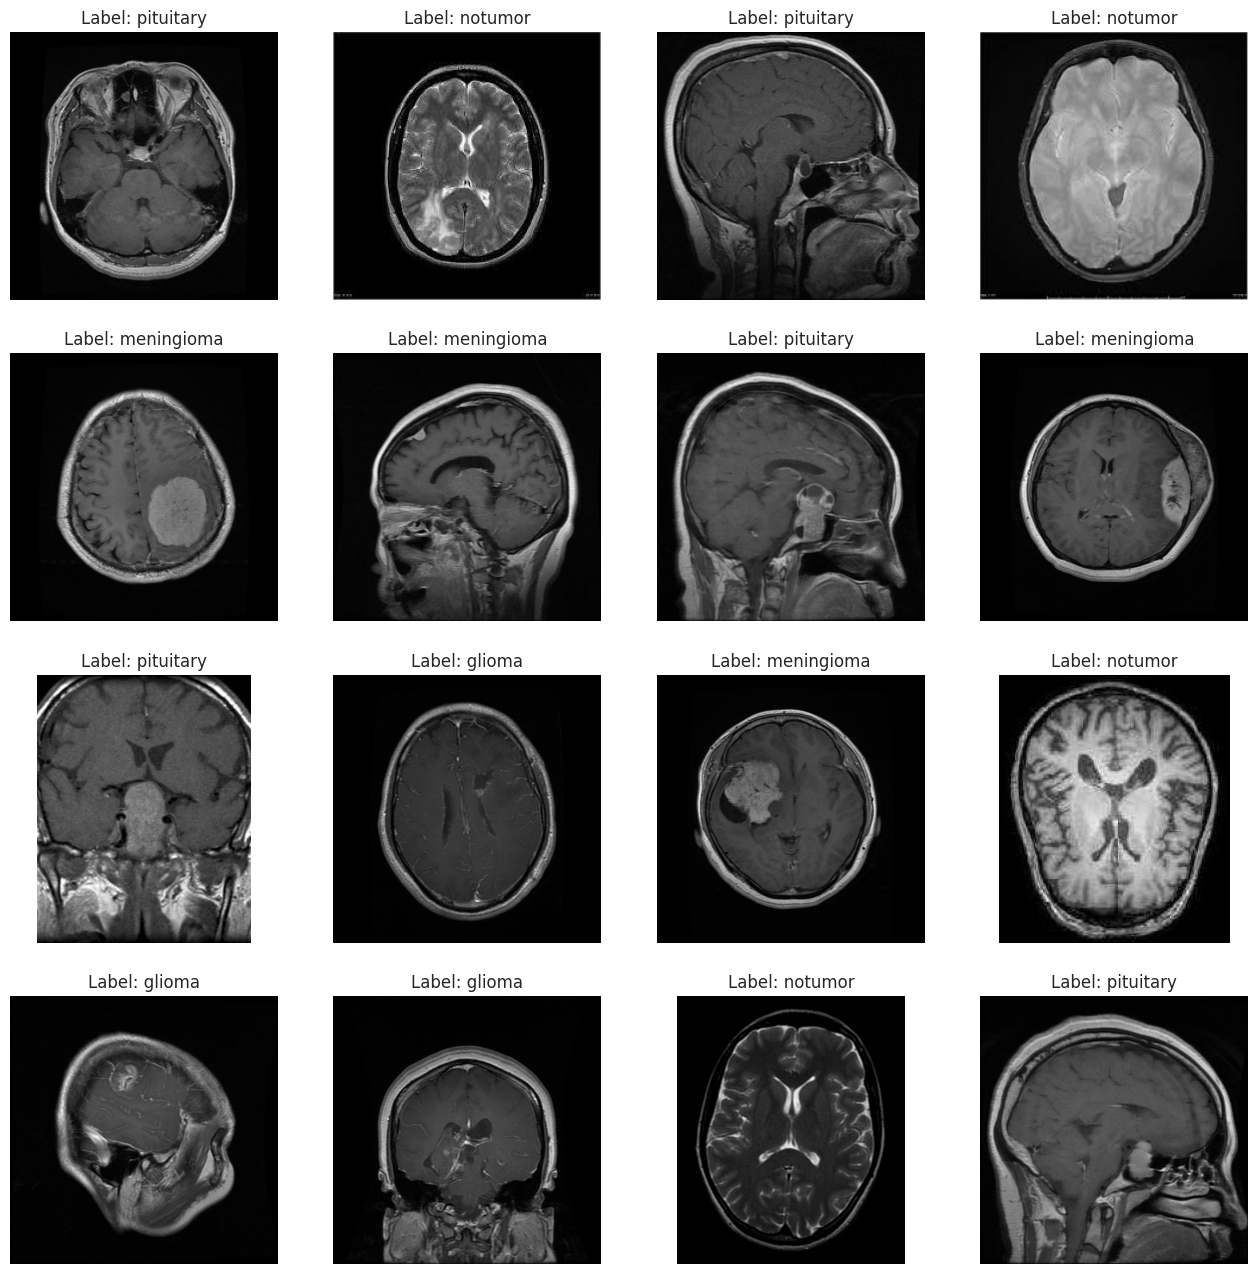

In [12]:
plt.figure(figsize=(16,16))
for ax , i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,ax+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title('Label: '+convert_code(y_train[i]))

# **Build CNN model**

In [13]:
from keras.metrics import Precision, Recall

model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (7,7), input_shape=(200, 200, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())


model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='softmax'))


model.compile(optimizer=SGD(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', Precision(), Recall()])


# Data Augmentation

In [28]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)
s = 200
train = generator_train.flow_from_directory(trainpath +'Training', target_size=(s, s),batch_size=32, class_mode= "categorical", color_mode='rgb')

test = generator_test.flow_from_directory(testpath + 'Testing', target_size=(s, s),
                                              batch_size=32, class_mode= "categorical", color_mode='rgb')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      3200      
                                                                 
 batch_normalization (Batch  (None, 200, 200, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     401536    
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 128)     512       
 chNormalization)                                                
                                                        

In [20]:
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-5, patience = 12, verbose = 1)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model_mcp = ModelCheckpoint(filepath = 'model_weights.h5', monitor = 'val_categorical_accuracy',
                      save_best_only = True, verbose = 1)

# Fiting the model.
history = model.fit(train, steps_per_epoch=5712//32, epochs=15, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model_es, model_rlr, model_mcp])

Epoch 1/15
178/178 [==============================] - ETA: 0s - loss: 0.5296 - categorical_accuracy: 0.7982 - precision: 0.8210 - recall: 0.7727
Epoch 1: val_categorical_accuracy improved from -inf to 0.22969, saving model to model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 48s 269ms/step - loss: 0.5296 - categorical_accuracy: 0.7982 - precision: 0.8210 - recall: 0.7727 - val_loss: 2.0080 - val_categorical_accuracy: 0.2297 - val_precision: 0.2297 - val_recall: 0.2297 - lr: 0.0010
Epoch 2/15
178/178 [==============================] - ETA: 0s - loss: 0.3805 - categorical_accuracy: 0.8590 - precision: 0.8697 - recall: 0.8412
Epoch 2: val_categorical_accuracy improved from 0.22969 to 0.34844, saving model to model_weights.h5
178/178 [==============================] - 45s 249ms/step - loss: 0.3805 - categorical_accuracy: 0.8590 - precision: 0.8697 - recall: 0.8412 - val_loss: 1.9374 - val_categorical_accuracy: 0.3484 - val_precision: 0.3480 - val_recall: 0.3398 - lr: 0.0010
Epoch 3/15
178/178 [==============================] - ETA: 0s - loss: 0.2799 - categorical_accuracy: 0.8930 - precision: 0.9019 - recall: 0.8808
Epoch 3: val_categorical_accuracy improved from 0.34844 to 0.79062, saving model to model_weights.h5
17

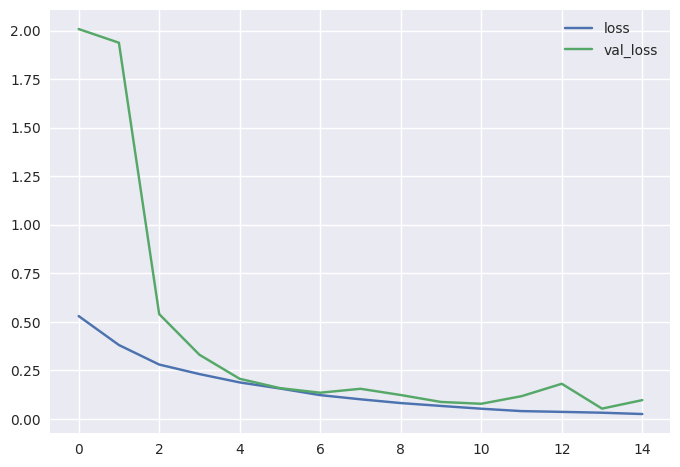

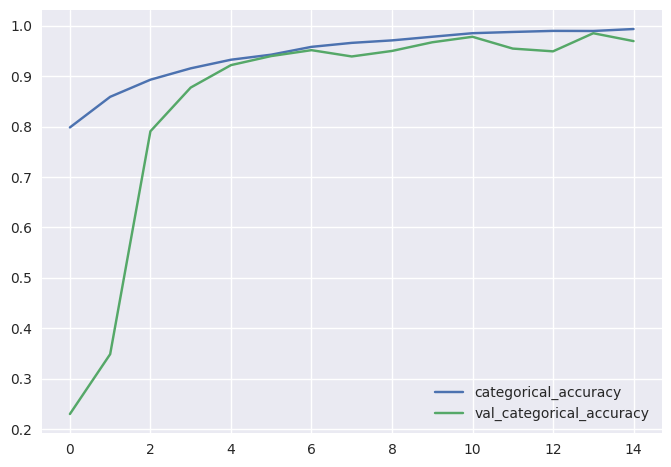

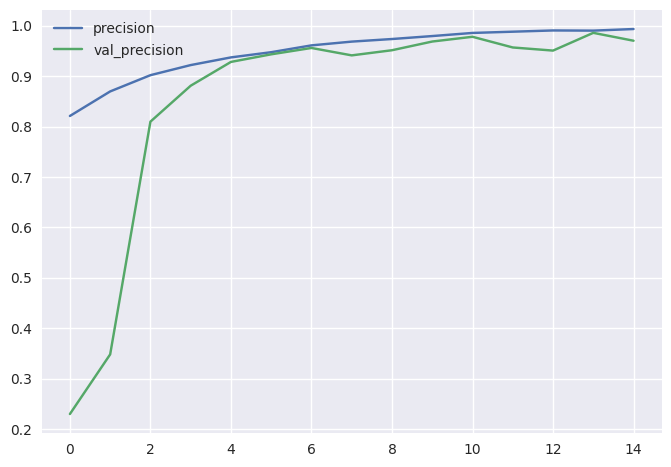

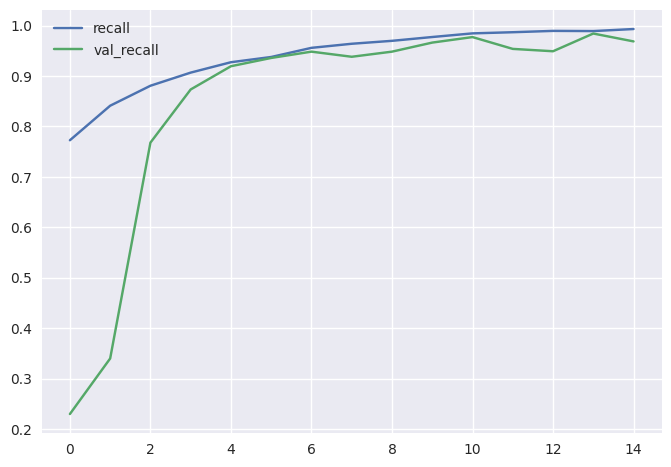

In [22]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy','val_categorical_accuracy']].plot();
history_frame.loc[:, ['precision','val_precision']].plot()
history_frame.loc[:, ['recall','val_recall']].plot();

In [23]:
loss, accuracy,perssion , recall = model.evaluate(test)
f1 = 2*((perssion*recall)/(perssion+recall))
print('Test Metrics:')
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {perssion}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

41/41 [==============================] - 9s 225ms/step - loss: 0.0985 - categorical_accuracy: 0.9718 - precision: 0.9732 - recall: 0.9695
Test Metrics:
Loss: 0.09849075973033905
Accuracy: 0.9717772603034973
Precision: 0.9732006192207336
Recall: 0.9694889187812805
F1 Score: 0.9713412232156712


# **Resnet50**

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze layers of ResNet
for layer in resnet.layers:
    layer.trainable = False

# Flatten the output of ResNet
x = Flatten()(resnet.output)

# Add fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(4, activation='softmax')(x)  # Adjust units for the number of classes
model_res = Model(inputs=resnet.input, outputs=output)

# Compile the model
model_res.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['categorical_accuracy', Precision(), Recall()])
history_res = model_res.fit(train, steps_per_epoch=5712//32, epochs=15, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model_es, model_rlr, model_mcp])

Epoch 1/15
178/178 [==============================] - ETA: 0s - loss: 2.8952 - categorical_accuracy: 0.4933 - precision_1: 0.5566 - recall_1: 0.3776
Epoch 1: val_categorical_accuracy did not improve from 0.98516
178/178 [==============================] - 48s 243ms/step - loss: 2.8952 - categorical_accuracy: 0.4933 - precision_1: 0.5566 - recall_1: 0.3776 - val_loss: 1.1671 - val_categorical_accuracy: 0.4555 - val_precision_1: 0.8192 - val_recall_1: 0.1734 - lr: 0.0010
Epoch 2/15
178/178 [==============================] - ETA: 0s - loss: 1.1327 - categorical_accuracy: 0.4312 - precision_1: 0.8879 - recall_1: 0.1868
Epoch 2: val_categorical_accuracy did not improve from 0.98516
178/178 [==============================] - 43s 243ms/step - loss: 1.1327 - categorical_accuracy: 0.4312 - precision_1: 0.8879 - recall_1: 0.1868 - val_loss: 1.1403 - val_categorical_accuracy: 0.4094 - val_precision_1: 0.7733 - val_recall_1: 0.1945 - lr: 0.0010
Epoch 3/15
178/178 [==============================] - 

In [31]:
model_res.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

<Axes: >

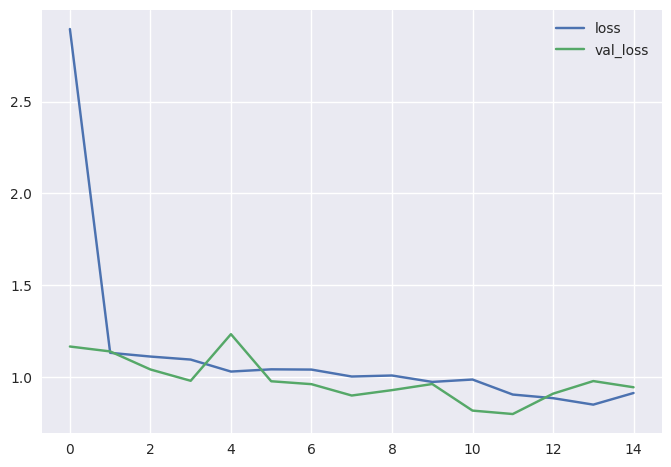

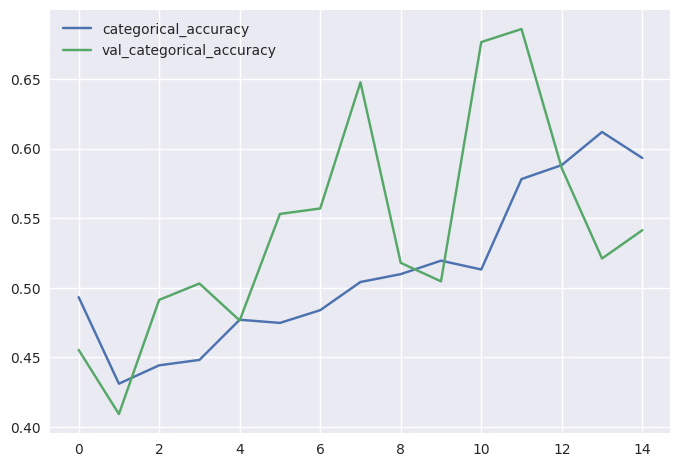

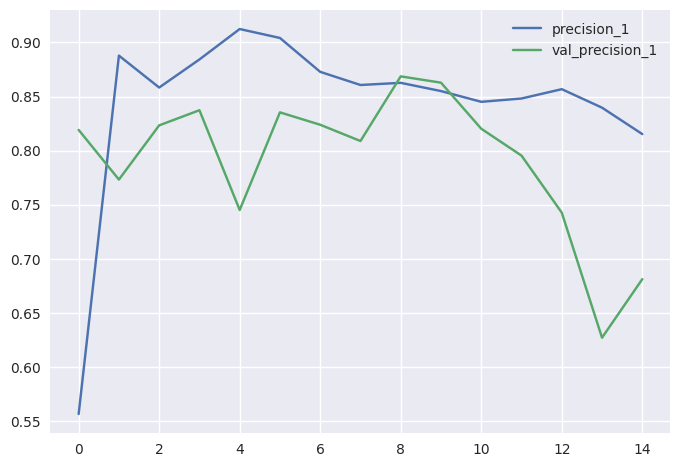

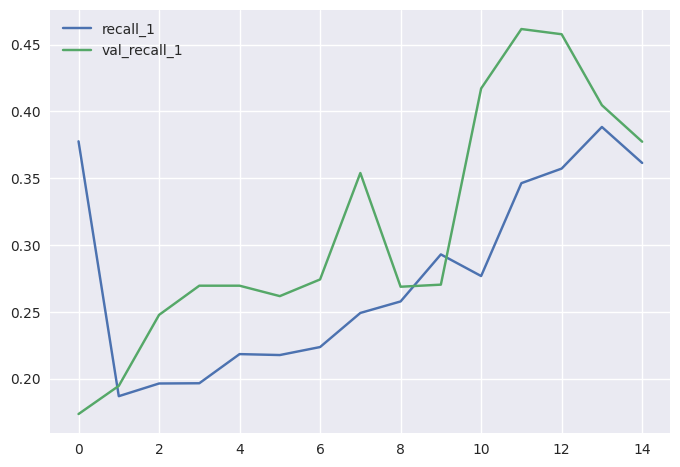

In [32]:
history_res_frame = pd.DataFrame(history_res.history)
history_res_frame[['loss', 'val_loss']].plot()
history_res_frame[['categorical_accuracy', 'val_categorical_accuracy']].plot()
history_res_frame[['precision_1', 'val_precision_1']].plot()
history_res_frame[['recall_1', 'val_recall_1']].plot()

In [33]:
loss, accuracy,perssion , recall = model_res.evaluate(test)
f1 = 2*((perssion*recall)/(perssion+recall))
print('Test Metrics:')
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {perssion}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

41/41 [==============================] - 10s 223ms/step - loss: 0.9452 - categorical_accuracy: 0.5400 - precision_1: 0.6748 - recall_1: 0.3783
Test Metrics:
Loss: 0.9452295303344727
Accuracy: 0.5400457382202148
Precision: 0.6748299598693848
Recall: 0.37833714485168457
F1 Score: 0.484848490107331


# **Resnet with different hyperparamters**

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load the ResNet50 model without the top layers
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze layers of ResNet
for layer in resnet.layers:
    layer.trainable = False

# Create a Sequential model
model_res = Sequential()

model_res.add(resnet)
model_res.add(Flatten())
model_res.add(Dense(1024, activation='relu'))
model_res.add(Dropout(0.25))
model_res.add(Dense(512, activation='relu'))
model_res.add(Dropout(0.25))
model_res.add(Dense(4, activation='softmax'))  # Adjust units for the number of classes


model_res.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',  metrics=['categorical_accuracy', Precision(), Recall()])

history_res = model_res.fit(train, steps_per_epoch=5712//32, epochs=10, validation_data=test, validation_steps=1311//32,
                             callbacks=[model_es, model_rlr, model_mcp])


Epoch 1/10
178/178 [==============================] - ETA: 0s - loss: 1.3088 - categorical_accuracy: 0.4167 - precision_2: 0.5818 - recall_2: 0.2129
Epoch 1: val_categorical_accuracy improved from -inf to 0.41641, saving model to model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 69s 364ms/step - loss: 1.3088 - categorical_accuracy: 0.4167 - precision_2: 0.5818 - recall_2: 0.2129 - val_loss: 1.1612 - val_categorical_accuracy: 0.4164 - val_precision_2: 0.8052 - val_recall_2: 0.1680 - lr: 0.0010
Epoch 2/10
178/178 [==============================] - ETA: 0s - loss: 1.1112 - categorical_accuracy: 0.4893 - precision_2: 0.7501 - recall_2: 0.2278
Epoch 2: val_categorical_accuracy improved from 0.41641 to 0.47734, saving model to model_weights.h5
178/178 [==============================] - 72s 406ms/step - loss: 1.1112 - categorical_accuracy: 0.4893 - precision_2: 0.7501 - recall_2: 0.2278 - val_loss: 1.1171 - val_categorical_accuracy: 0.4773 - val_precision_2: 0.8000 - val_recall_2: 0.1844 - lr: 0.0010
Epoch 3/10
178/178 [==============================] - ETA: 0s - loss: 1.0343 - categorical_accuracy: 0.5414 - precision_2: 0.7629 - recall_2: 0.2843
Epoch 3: val_categorical_accuracy improved from 0.47734 to 0.57891, saving mode

<Axes: >

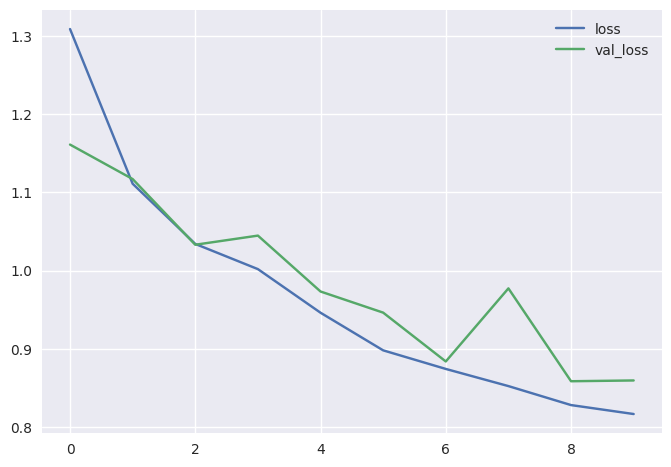

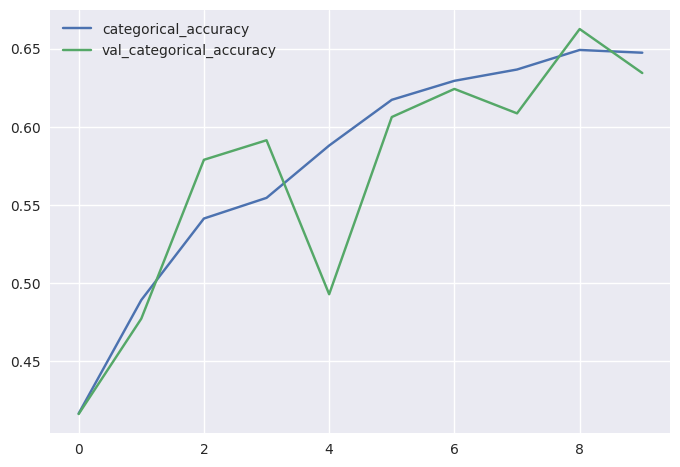

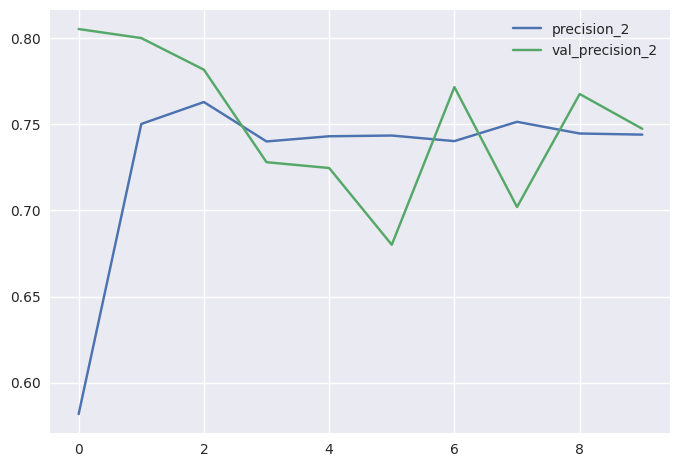

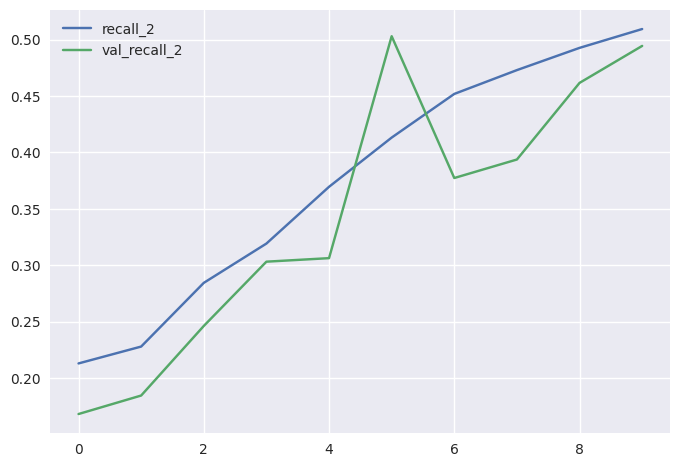

In [36]:
history_res_frame = pd.DataFrame(history_res.history)
history_res_frame[['loss', 'val_loss']].plot()
history_res_frame[['categorical_accuracy', 'val_categorical_accuracy']].plot()
history_res_frame[['precision_2', 'val_precision_2']].plot()
history_res_frame[['recall_2', 'val_recall_2']].plot()

In [37]:
loss, accuracy,perssion , recall = model_res.evaluate(test)
f1 = 2*((perssion*recall)/(perssion+recall))
print('Test Metrics:')
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {perssion}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

41/41 [==============================] - 7s 179ms/step - loss: 0.8583 - categorical_accuracy: 0.6445 - precision_2: 0.7408 - recall_2: 0.4928
Test Metrics:
Loss: 0.8582876324653625
Accuracy: 0.6445461511611938
Precision: 0.7408257126808167
Recall: 0.49275362491607666
F1 Score: 0.5918460924704575


#          **VGG**

In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))  # Assuming input shape is (200, 200, 3)


for layer in vgg.layers:
    layer.trainable = False

# Flatten the output of VGG16
x = Flatten()(vgg.output)

# Add fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(4, activation='softmax')(x)  # Adjust units for the number of classes

model_vgg = Model(inputs=vgg.input, outputs=output)

# Compile the model with Adam optimizer
model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',  metrics=['categorical_accuracy', Precision(), Recall()])
history_vgg = model_vgg.fit(train, steps_per_epoch=5712//32, epochs=10, validation_data=test, validation_steps=1311//32,
                            callbacks=[model_es, model_rlr, model_mcp])


Epoch 1/10
178/178 [==============================] - ETA: 0s - loss: 0.8223 - categorical_accuracy: 0.7681 - precision_3: 0.7897 - recall_3: 0.7417
Epoch 1: val_categorical_accuracy improved from 0.66250 to 0.83750, saving model to model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 56s 308ms/step - loss: 0.8223 - categorical_accuracy: 0.7681 - precision_3: 0.7897 - recall_3: 0.7417 - val_loss: 0.4040 - val_categorical_accuracy: 0.8375 - val_precision_3: 0.8534 - val_recall_3: 0.8141 - lr: 0.0010
Epoch 2/10
178/178 [==============================] - ETA: 0s - loss: 0.3362 - categorical_accuracy: 0.8731 - precision_3: 0.8835 - recall_3: 0.8614
Epoch 2: val_categorical_accuracy improved from 0.83750 to 0.86719, saving model to model_weights.h5
178/178 [==============================] - 44s 245ms/step - loss: 0.3362 - categorical_accuracy: 0.8731 - precision_3: 0.8835 - recall_3: 0.8614 - val_loss: 0.3431 - val_categorical_accuracy: 0.8672 - val_precision_3: 0.8855 - val_recall_3: 0.8516 - lr: 0.0010
Epoch 3/10
178/178 [==============================] - ETA: 0s - loss: 0.2951 - categorical_accuracy: 0.8933 - precision_3: 0.9042 - recall_3: 0.8806
Epoch 3: val_categorical_accuracy improved from 0.86719 to 0.89297, saving mode

In [40]:
model_vgg.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

<Axes: >

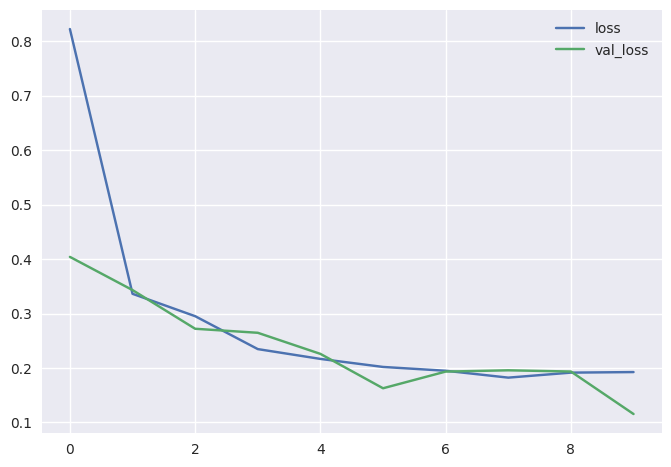

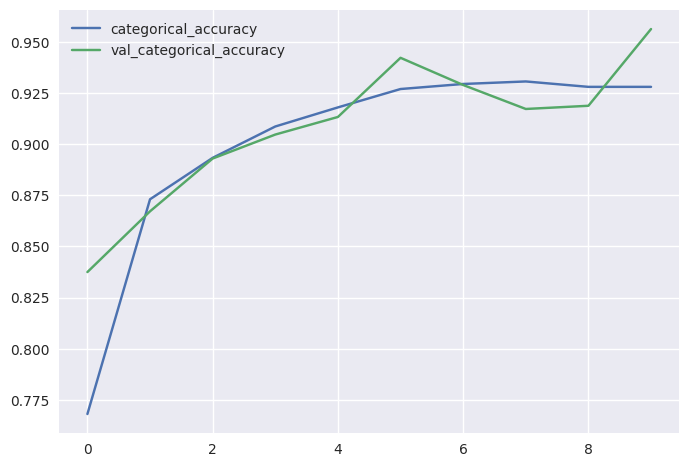

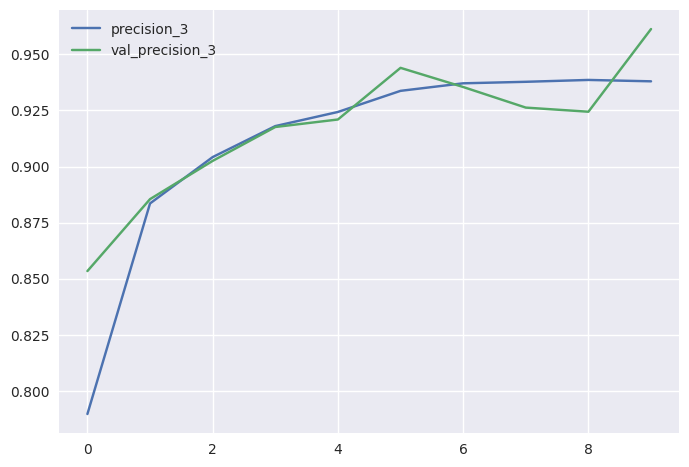

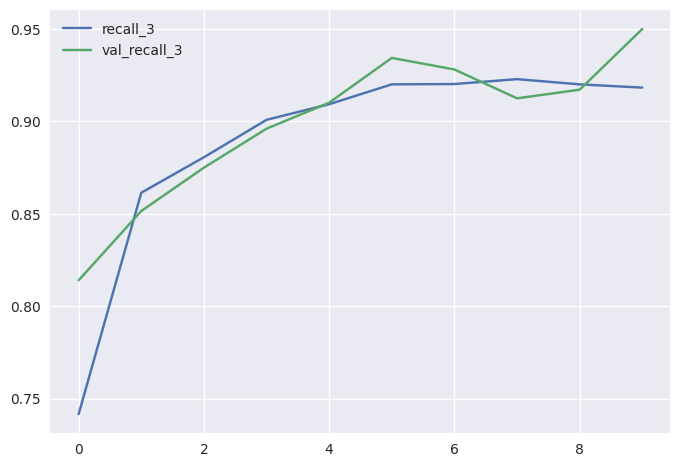

In [42]:
import pandas as pd

history_vgg_frame = pd.DataFrame(history_vgg.history)
history_vgg_frame[['loss', 'val_loss']].plot()
history_vgg_frame[['categorical_accuracy', 'val_categorical_accuracy']].plot()
history_vgg_frame[['precision_3', 'val_precision_3']].plot()
history_vgg_frame[['recall_3', 'val_recall_3']].plot()

In [41]:
loss, accuracy,perssion , recall = model_vgg.evaluate(test)
f1 = 2*((perssion*recall)/(perssion+recall))
print('Test Metrics:')
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {perssion}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

41/41 [==============================] - 15s 359ms/step - loss: 0.1244 - categorical_accuracy: 0.9519 - precision_3: 0.9553 - recall_3: 0.9458
Test Metrics:
Loss: 0.12436453998088837
Accuracy: 0.9519450664520264
Precision: 0.955315887928009
Recall: 0.9458428621292114
F1 Score: 0.9505557741016014
